# IBM Exploratory Data Analysis for Machine Learning
Course Project:  EDA and Feature Engineering

In [9]:
# Data Source: https://majorprojects.alberta.ca/
# Major Projects are valued at $5 million or greater

## Data Preparation

Import necessary libraries

In [102]:
import pandas as pd
import json
import folium # map rendering library

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from sklearn.cluster import KMeans
import scipy.stats

Create a Pandas DataFrame from a Excel file

In [11]:
data = pd.read_excel('./Major Projects Export.xlsx')
print(data.shape)
data.head()

(710, 14)


,ProjectId,Name,Estimated Cost,Municipality,Schedule,Sector,Type,Stage,Developer,Contractor,Architect,Project Website,Location,Detail
0,7,StoneGate Landing,3.000000e+09,Calgary,2010 - 2021,Mixed-Use,NaN,Under Construction,WAM Development Group / AIMCo,NaN,NaN,www.stonegatelanding.ca/,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...",StoneGate Landing is slated to be the largest ...
1,11,Shepard Station Suburban Office Campus Building 1,2.200000e+07,Calgary,2019 - 2020,Commercial,Office: Low-Rise,Under Construction,Shepard Development Corp.,Shepard Development Corporation / CANA / ACE C...,NaN,http://www.shepardstation.com/,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...",The Shepard Suburban Office Campus is a 33-acr...
2,22,Barron Building Renovation,1.000000e+08,Calgary,Commencing 2021,Residential,Apartment: Mid-Rise,Proposed,Strategic Group,NaN,NaN,https://www.strategicgroup.ca/commercial/calga...,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...",Conversion of the Barron Building into a 94 un...
3,26,Quarry Crossing II Office Building,7.280000e+07,Calgary,NaN,Commercial,Office: Low-Rise,Proposed,Remington Development Corp.,NaN,NaN,http://www.remingtoncorp.com/leasingLocation.p...,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...","A 512,000 sq ft office building project in Cal..."
4,32,Nolan Hill TownHomes,5.000000e+06,Calgary,NaN,Residential,Townhouses,Proposed,Jayman Modus,NaN,NaN,NaN,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...",NaN


Extract from geojson the start location coordinates (Longitude, Latitude)

In [12]:
data['Location'] = data['Location'].apply(json.loads)

Latitude = []
Longitude = []

for i in range(len(data)):
    geo = data['Location'][i]['geometry']
    if geo['type'] == 'Point':
        Longitude.append(geo['coordinates'][0])
        Latitude.append(geo['coordinates'][1])
    elif geo['type'] == 'LineString':
            Longitude.append(geo['coordinates'][0][0])
            Latitude.append(geo['coordinates'][0][1])
    elif geo['geometries'][0]['type'] == 'Point':
            Longitude.append(data['Location'][i]['geometry']['geometries'][0]['coordinates'][0])
            Latitude.append(data['Location'][i]['geometry']['geometries'][0]['coordinates'][1])
    elif geo['geometries'][0]['type'] == 'LineString':
            Longitude.append(data['Location'][i]['geometry']['geometries'][0]['coordinates'][0][0])
            Latitude.append(data['Location'][i]['geometry']['geometries'][0]['coordinates'][0][1])
    else:
        print('Error: New Type')
        
data['Start Latitude'] = Latitude
data['Start Longitude'] = Longitude

Drop rows where there is no Estimated Cost and divide cost by a million

In [13]:
data = data.dropna(subset=['Estimated Cost'])
data['Estimated Cost'] = data['Estimated Cost']/(1e6)
data.shape

(702, 16)

Change Schedule Completion, assume 2027 for all proposed Project w/o Schedule

In [14]:
data['Schedule'] = data['Schedule'].str[-4:]
data['Schedule'] = data['Schedule'].fillna(2027)
data['Schedule'] = data['Schedule'].astype(int)

Rename Colums

In [15]:
data.rename(columns={'Name':'Project Name', 'Estimated Cost':'Estimated Cost (millions)', 'Schedule':'Forecasted Completion'}, inplace=True)

Assume that Projects that were under construction before 2020 are completed (unless are Cancelled or On Hold)

In [16]:
data.loc[data['Forecasted Completion']<2020, 'Stage']='Completed'
data['Stage'] = data['Stage'].replace('Under Construction','Started')
data['Stage'].value_counts()

Proposed     323
Started      311
Completed     68
Name: Stage, dtype: int64

Make Type equal to Sector when there is no type (except Infrastructure)

In [17]:
data['Type'] = data['Type'].fillna(data['Sector'])
data['Type'] = data['Type'].replace('Infrastructure','Other')

Drop columns not needed and set ProjectId as index

In [18]:
data.drop(columns=['Contractor','Architect','Project Website', 'Detail', 'Location'], inplace=True)
data.set_index('ProjectId',inplace=True)
data.head()

,Project Name,Estimated Cost (millions),Municipality,Forecasted Completion,Sector,Type,Stage,Developer,Start Latitude,Start Longitude
ProjectId,,,,,,,,,,
7,StoneGate Landing,3000.0,Calgary,2021,Mixed-Use,Mixed-Use,Started,WAM Development Group / AIMCo,51.172501,-113.975800
11,Shepard Station Suburban Office Campus Building 1,22.0,Calgary,2020,Commercial,Office: Low-Rise,Started,Shepard Development Corp.,50.931721,-113.970596
22,Barron Building Renovation,100.0,Calgary,2021,Residential,Apartment: Mid-Rise,Proposed,Strategic Group,51.046070,-114.076614
26,Quarry Crossing II Office Building,72.8,Calgary,2027,Commercial,Office: Low-Rise,Proposed,Remington Development Corp.,50.966900,-114.002899
32,Nolan Hill TownHomes,5.0,Calgary,2027,Residential,Townhouses,Proposed,Jayman Modus,51.162041,-114.160912


In [19]:
data.isnull().any()

Project Name                 False
Estimated Cost (millions)    False
Municipality                 False
Forecasted Completion        False
Sector                       False
Type                         False
Stage                        False
Developer                    False
Start Latitude               False
Start Longitude              False
dtype: bool

## Data Exploration

### Descriptive Statistics

In [20]:
data.describe(include=[object]).transpose()

,count,unique,top,freq
Project Name,702,702,Inter Pipeline Acrylic Acid Plant,1
Municipality,702,148,Calgary,184
Sector,702,11,Infrastructure,158
Type,702,56,Roadwork,79
Stage,702,3,Proposed,323
Developer,702,416,City of Calgary,33


In [21]:
data.describe(exclude=['int64','object']).transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
Estimated Cost (millions),702.0,219.99,967.22,5.00,10.02,22.55,71.80,16000.00
Forecasted Completion,702.0,2022.10,3.12,2014.00,2020.00,2021.00,2024.00,2027.00
Start Latitude,702.0,52.51,1.81,49.02,51.04,52.75,53.55,58.48
Start Longitude,702.0,-113.80,1.62,-119.77,-114.08,-113.71,-113.39,-110.01


The Most Expensive Projects are (above $5m):

In [22]:
data[data['Estimated Cost (millions)']>5000]

,Project Name,Estimated Cost (millions),Municipality,Forecasted Completion,Sector,Type,Stage,Developer,Start Latitude,Start Longitude
ProjectId,,,,,,,,,,
614,Trans Mountain Pipeline Expansion,7400.0,Yellowhead County|Improvement District No. 12 ...,2019,Pipelines,Pipelines,Completed,Government of Canada/Trans Mountain Corporation,53.543042,-113.361502
873,"Green Line LRT, Stage 1",5500.0,Calgary,2026,Infrastructure,Transit,Proposed,City of Calgary,50.931484,-113.968971
3579,Keystone XL,10000.0,Cypress County|Provost No. 52|Special Area No....,2020,Pipelines,Pipelines,Started,TransCanada Energy Ltd.,52.635032,-111.275432
3735,SinoCan Global Upgrader and Petrochemical Faci...,8500.0,Lamont County,2021,Oil and Gas,Upgrader,Proposed,SinoCan Global,53.775939,-112.825255
3921,Telus Infrastructure Upgrades (Province wide),16000.0,Edmonton,2024,Industrial,Telecommunication,Started,TELUS,53.540116,-113.491361


Names and Number of unique project types

In [23]:
print(data.Type.unique())
len(data.Type.unique())

['Mixed-Use' 'Office: Low-Rise' 'Apartment: Mid-Rise' 'Townhouses'
 'Distribution Centre' 'Arts and Culture' 'Business Park' 'Roadwork'
 'Transit' 'Office Renovation' 'Research Centre' 'Shopping Plaza'
 'Apartment: High-Rise' 'Telecommunication' 'Water/Wastewater' 'Other'
 'Airport' 'Emergency Services' 'Flood Mitigation' 'Health Care'
 'Administration' 'Post-Secondary' 'Library' 'Continuing Care'
 'Student Residence' 'Religious' 'School' 'Gas' 'Oil Sands: In Situ'
 'Oil Sands: Mining' 'Upgrader' 'Bioproduct' 'Chemical' 'Metals'
 'Military' 'Pipelines' 'Natural Gas' 'Wind' 'Apartment: Low-Rise'
 'Attractions' 'Sports Facility' 'Hotel' 'Park' 'Museum' 'Solar'
 'Event Space' 'Community Centre' 'Agriculture' 'Community' 'Power Centre'
 'Transmission Line' 'Distribution/Storage' 'Big-Box Store'
 'Shopping Mall' 'Auto Dealership' 'Bioenergy']


56

### Bar Chart of Project Types

<AxesSubplot:>

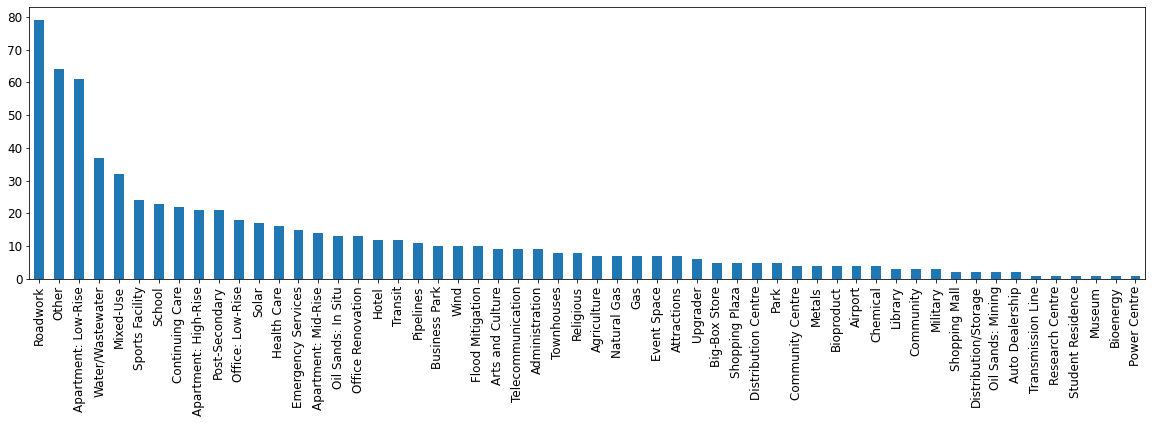

In [24]:
data.Type.value_counts().plot.bar(figsize = [20, 5], fontsize = 12)

The Projects types with only 1 or 2 Projects are:

In [25]:
data.Type.value_counts().to_frame().tail(10).transpose()

,Shopping Mall,Distribution/Storage,Oil Sands: Mining,Auto Dealership,Transmission Line,Research Centre,Student Residence,Museum,Bioenergy,Power Centre
Type,2,2,2,2,1,1,1,1,1,1


### Names and Number of Unique Sectors

In [26]:
print(len(data.Sector.unique()))
data.Sector.value_counts().to_frame().transpose()

11


,Infrastructure,Institutional,Residential,Tourism / Recreation,Commercial,Industrial,Power,Oil and Gas,Mixed-Use,Retail,Pipelines
Sector,158,127,111,78,50,42,42,32,32,19,11


<AxesSubplot:>

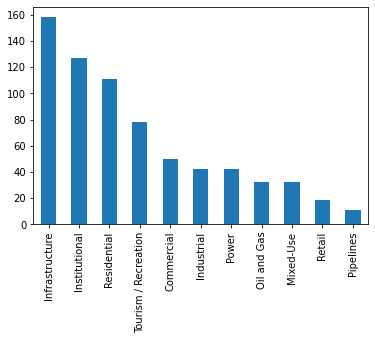

In [27]:
data.Sector.value_counts().plot.bar()

### (Public) Infrastructure Sector

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

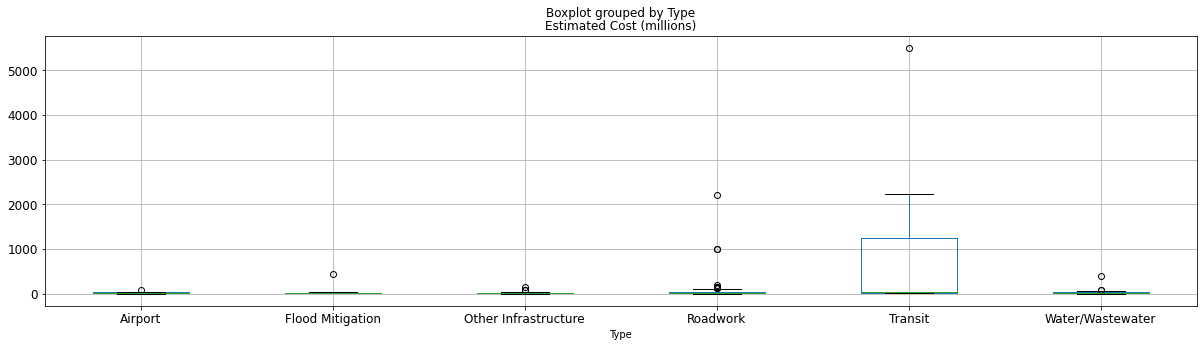

In [28]:
data.loc[(data['Sector']=='Infrastructure') & (data['Type']=='Other'), 'Type']='Other Infrastructure'
data[data['Sector']=='Infrastructure'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Institutional Sector

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

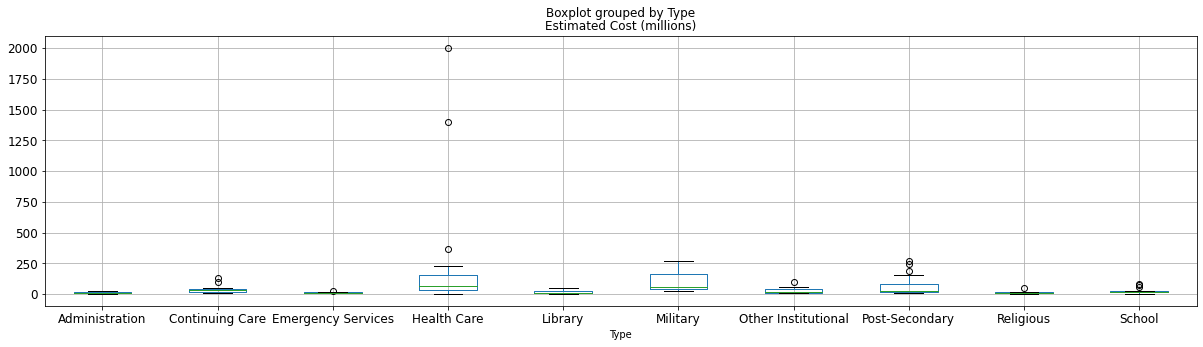

In [29]:
data.loc[(data['Sector']=='Institutional') & (data['Type']=='Other'), 'Type']='Other Institutional'
data[data['Sector']=='Institutional'].boxplot('Estimated Cost (millions)','Type',figsize = [20, 5], fontsize = 12)

### Residential Sector
Corrections: High-Rise above $200m are Community Type and Student Residence is Other Residential Type

In [30]:
data['Type'] = data['Type'].replace('Student Residence','Other')
data.loc[(data['Sector']=='Residential') & (data['Type']=='Other'), 'Type']='Other Residential'
data.loc[(data['Sector']=='Residential') & (data['Type']=='Apartment: High-Rise') & (data['Estimated Cost (millions)']>200), 'Type']='Community'

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

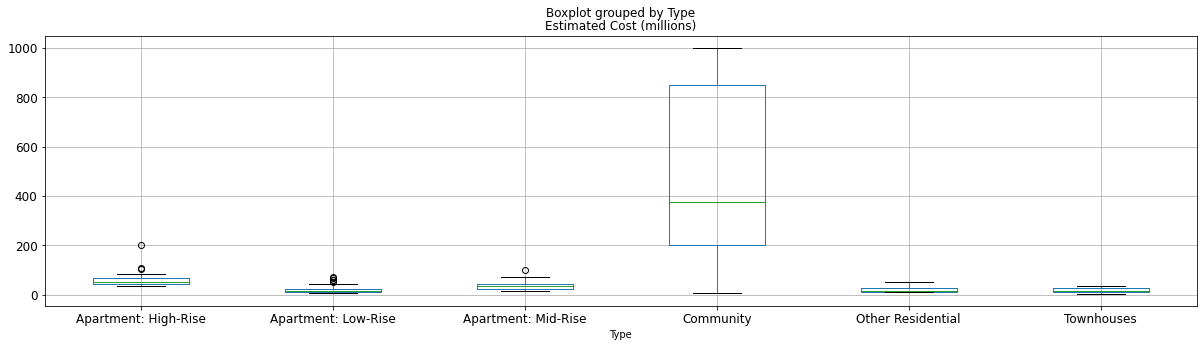

In [23]:
data[data['Sector']=='Residential'].boxplot('Estimated Cost (millions)','Type',figsize = [20, 5], fontsize = 12)

### Tourism Sector
Correction: Museum is an Attractions Type and Tourism is the Sector

In [31]:
data['Sector'] = data['Sector'].replace('Tourism / Recreation','Tourism')
data.loc[(data['Sector']=='Tourism') & (data['Type']=='Other'), 'Type']='Other Tourism'
data['Type'] = data['Type'].replace('Museum','Attractions')

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

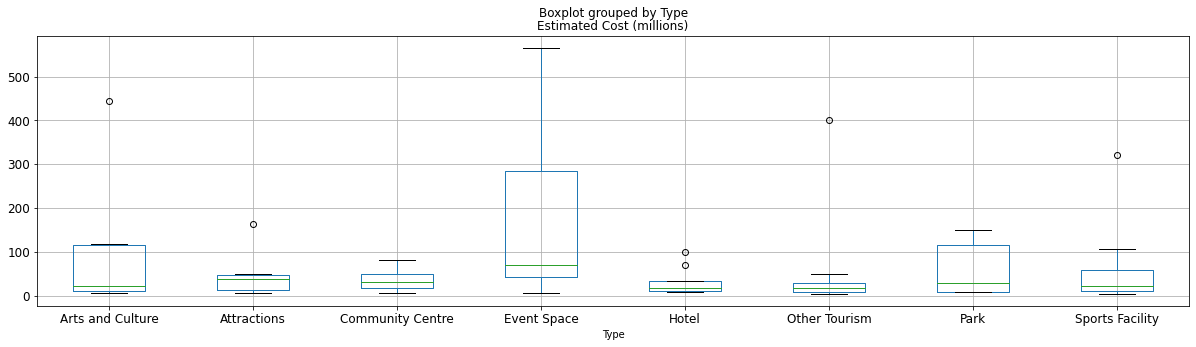

In [32]:
data[data['Sector']=='Tourism'].boxplot('Estimated Cost (millions)','Type',figsize = [20, 5], fontsize = 12)

### Commercial Sector
Correction: There is only Office Low-Rise Type, renamed to Offices

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

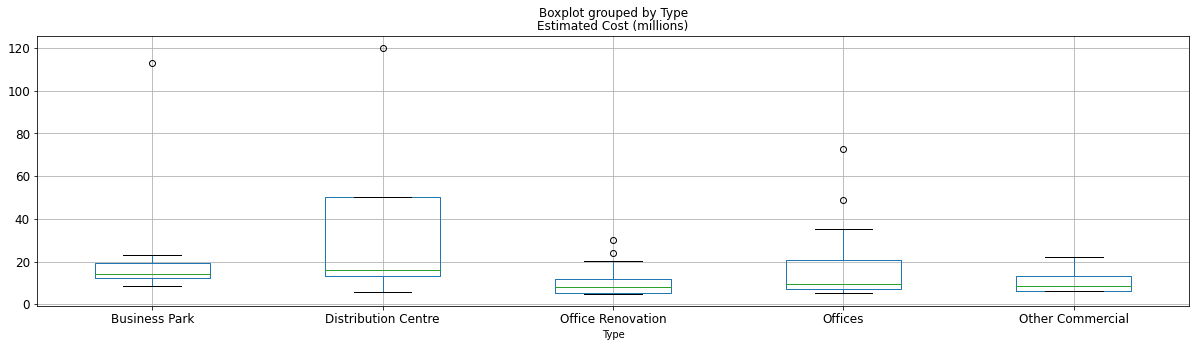

In [33]:
data.loc[(data['Sector']=='Commercial') & (data['Type']=='Other'), 'Type']='Other Commercial'
data['Type'] = data['Type'].replace('Office: Low-Rise','Offices')
data[data['Sector']=='Commercial'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Power Sector
Corrections: Bioenergy and Transmisson Line Types renamed to Other

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

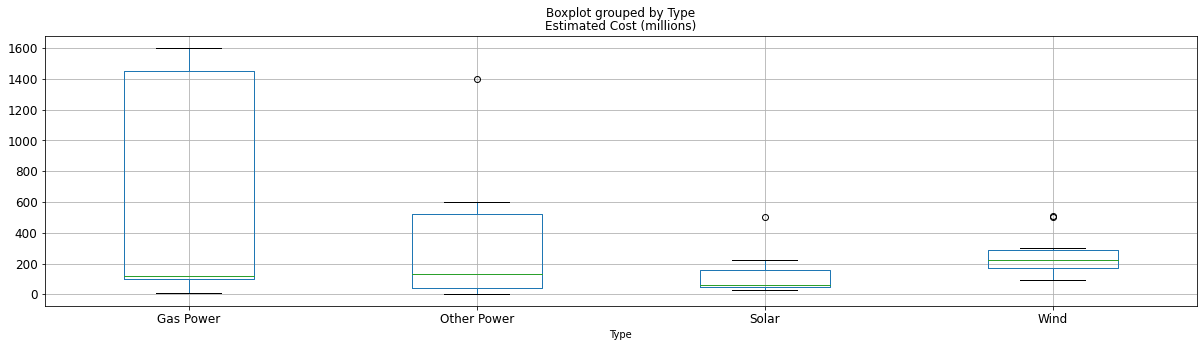

In [34]:
data['Type'] = data['Type'].replace('Bioenergy','Other')
data['Type'] = data['Type'].replace('Natural Gas','Gas Power')
data['Type'] = data['Type'].replace('Transmission Line','Other')
data.loc[(data['Sector']=='Power') & (data['Type']=='Other'), 'Type']='Other Power'
data[data['Sector']=='Power'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Industrial Sector
Correction: Research Centre Type renamed to Other Industrial Type

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

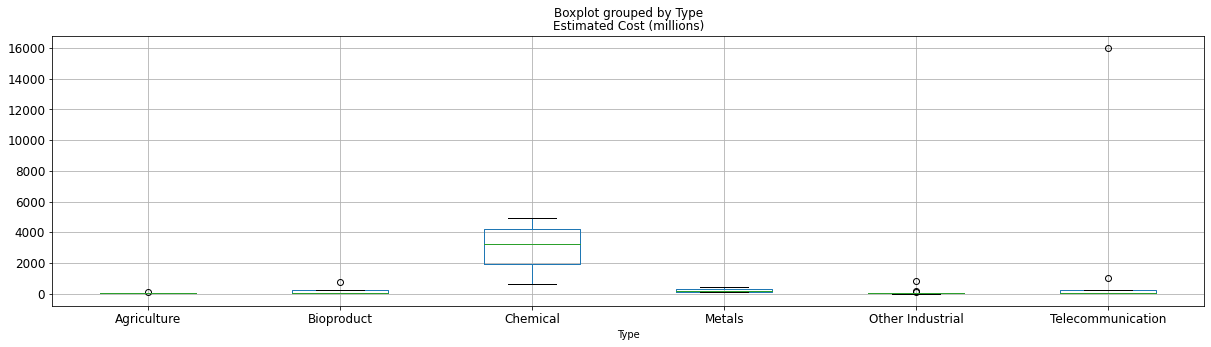

In [35]:
data['Type'] = data['Type'].replace('Research Centre','Other')
data.loc[(data['Sector']=='Industrial') & (data['Type']=='Other'), 'Type']='Other Industrial'
data[data['Sector']=='Industrial'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Oil and Gas Sector (Including Pipelines)

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

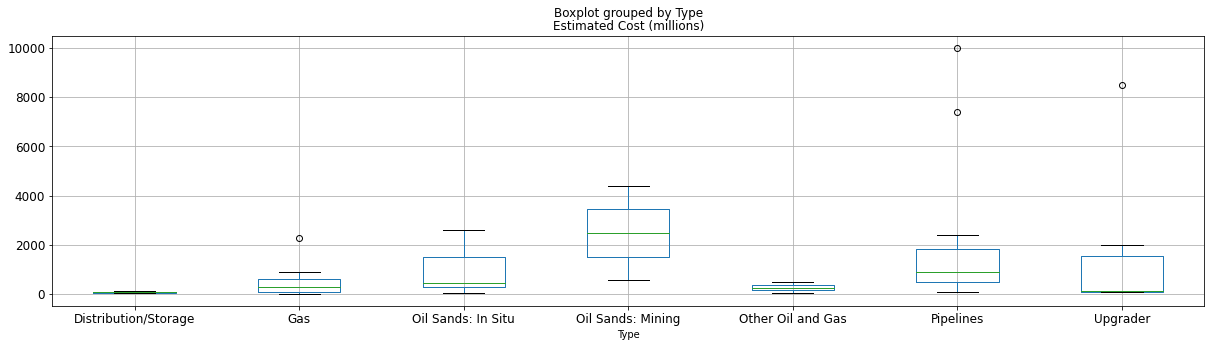

In [36]:
data['Sector'] = data['Sector'].replace('Pipelines','Oil and Gas')
data.loc[(data['Sector']=='Oil and Gas') & (data['Type']=='Other'), 'Type']='Other Oil and Gas'
data[data['Sector']=='Oil and Gas'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Retail Sector (Including Mixed-Use)
Correction: Power Centre Type renamed to Mixed-Use

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

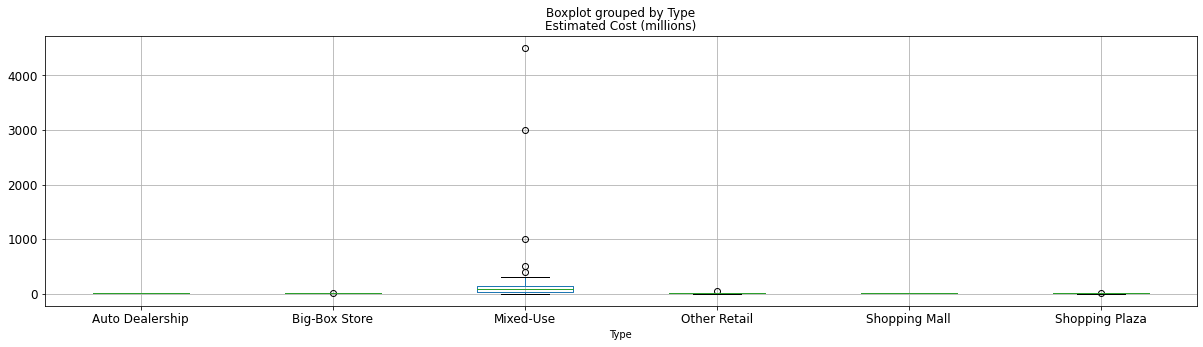

In [37]:
data['Sector'] = data['Sector'].replace('Mixed-Use','Retail')
data.loc[(data['Sector']=='Retail') & (data['Type']=='Other'), 'Type']='Other Retail'
data['Type'] = data['Type'].replace('Power Centre','Mixed-Use')
data[data['Sector']=='Retail'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Number of Unique Sectors and Types (after corrections)

In [38]:
print('Number of Unique Sectors:',len(data.Sector.unique()))
print('Number of Unique Types:',len(data.Type.unique()))

Number of Unique Sectors: 9
Number of Unique Types: 58


In [39]:
data[['Sector', 'Type', 'Project Name']].groupby(by=['Sector','Type']).count()

Project Name
Sector         Type                              
Commercial     Business Park                   10
               Distribution Centre              5
               Office Renovation               13
               Offices                         18
               Other Commercial                 4
Industrial     Agriculture                      7
               Bioproduct                       4
               Chemical                         4
               Metals                           4
               Other Industrial                14
               Telecommunication                9
Infrastructure Airport                          4
               Flood Mitigation                10
               Other Infrastructure            16
               Roadwork                        79
               Transit                         12
               Water/Wastewater                37
Institutional  Administration                   9
               Continuing Care                 22
               Emergency Services              15
               Health Care                     16
               Library                          3
               Military                         3
               Other Institutional              7
               Post-Secondary                  21
               Religious                        8
               School                          23
Oil and Gas    Distribution/Storage             2
               Gas                              7
               Oil Sands: In Situ              13
               Oil Sands: Mining                2
               Other Oil and Gas                2
               Pipelines                       11
               Upgrader                         6
Power          Gas Power                        7
               Other Power                      8
               Solar                           17
               Wind                            10
Residential    Apartment: High-Rise            18
               Apartment: Low-Rise             61
               Apartment: Mid-Rise             14
               Community                        6
               Other Residential                4
               Townhouses                       8
Retail         Auto Dealership                  2
               Big-Box Store                    5
               Mixed-Use                       33
               Other Retail                     4
               Shopping Mall                    2
               Shopping Plaza                   5
Tourism        Arts and Culture                 9
               Attractions                      8
               Community Centre                 4
               Event Space                      7
               Hotel                           12
               Other Tourism                    9
               Park                             5
               Sports Facility                 24

### Create map of Alberta using latitude and longitude values

In [40]:
AB_Coordinates = [54.5, -115]
AB_Projects_map = folium.Map(location=AB_Coordinates, zoom_start=6)
# add markers to map
for lat, lng, Name, Sector, Type in zip(data['Start Latitude'], data['Start Longitude'], data['Project Name'], data['Sector'], data['Type']):
    label = '{}, {}'.format(Name, Type)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],radius=5,popup=label,color='blue',fill=True,fill_color='#3186cc',fill_opacity=0.7,parse_html=False).add_to(AB_Projects_map)  
    
AB_Projects_map

In [34]:
data.head()

,Project Name,Estimated Cost (millions),Municipality,Forecasted Completion,Sector,Type,Stage,Developer,Start Latitude,Start Longitude
ProjectId,,,,,,,,,,
7,StoneGate Landing,3000.0,Calgary,2021,Retail,Mixed-Use,Started,WAM Development Group / AIMCo,51.172501,-113.975800
11,Shepard Station Suburban Office Campus Building 1,22.0,Calgary,2020,Commercial,Offices,Started,Shepard Development Corp.,50.931721,-113.970596
22,Barron Building Renovation,100.0,Calgary,2021,Residential,Apartment: Mid-Rise,Proposed,Strategic Group,51.046070,-114.076614
26,Quarry Crossing II Office Building,72.8,Calgary,2027,Commercial,Offices,Proposed,Remington Development Corp.,50.966900,-114.002899
32,Nolan Hill TownHomes,5.0,Calgary,2027,Residential,Townhouses,Proposed,Jayman Modus,51.162041,-114.160912


## Save the clean dataset to an Excel Spreadsheet

In [41]:
data.to_excel('MPData.xlsx', sheet_name='Major Projects')

### Cluster Projects by Geographical Region and Type

In [42]:
# one hot encoding
onehotregion = pd.get_dummies(data[['Type']], prefix="", prefix_sep="")
# add back estimated Start Coordinates
onehotregion['Start Latitude'] = data['Start Latitude']
onehotregion['Start Longitude'] = data['Start Longitude']
print(onehotregion.shape)
onehotregion.head()

(702, 60)


,Administration,Agriculture,Airport,Apartment: High-Rise,Apartment: Low-Rise,Apartment: Mid-Rise,Arts and Culture,Attractions,Auto Dealership,Big-Box Store,...,Solar,Sports Facility,Telecommunication,Townhouses,Transit,Upgrader,Water/Wastewater,Wind,Start Latitude,Start Longitude
ProjectId,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,51.172501,-113.975800
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,50.931721,-113.970596
22,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,51.046070,-114.076614
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,50.966900,-114.002899
32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,51.162041,-114.160912


In [45]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, random_state=123).fit(onehotregion)

# check how many cluster labels were generated for each row in the dataframe
len(kmeans.labels_)

702

In [46]:
# add Region labels
onehotregion.insert(0, 'Region', kmeans.labels_)
onehotregion.head()

,Region,Administration,Agriculture,Airport,Apartment: High-Rise,Apartment: Low-Rise,Apartment: Mid-Rise,Arts and Culture,Attractions,Auto Dealership,...,Solar,Sports Facility,Telecommunication,Townhouses,Transit,Upgrader,Water/Wastewater,Wind,Start Latitude,Start Longitude
ProjectId,,,,,,,,,,,,,,,,,,,,,
7,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,51.172501,-113.975800
11,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,50.931721,-113.970596
22,8,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,51.046070,-114.076614
26,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,50.966900,-114.002899
32,8,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,51.162041,-114.160912


### Add back Project Name and Cost

In [47]:
onehotregion['Estimated Cost (millions)'] = data['Estimated Cost (millions)']
onehotregion['Project Name'] = data['Project Name']

# move Project Name column to the first column
fixed_columns = [onehotregion.columns[-1]] + list(onehotregion.columns[:-1])
onehotregion = onehotregion[fixed_columns]

### Create a new Map color coded by Region

In [48]:
# create map
map_region = folium.Map(location=AB_Coordinates, zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, region in zip(onehotregion['Start Latitude'], onehotregion['Start Longitude'], onehotregion['Project Name'], onehotregion['Region']):
    label = folium.Popup(str(name) + ' Region ' + str(region), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[region-1],
        fill=True,
        fill_color=rainbow[region-1],
        fill_opacity=0.7).add_to(map_region)
       
map_region

### Label the regions by the main city or towns nearby

In [49]:
onehotregion['Region'] = onehotregion['Region'].replace({0: 'Edmonton', 1: 'Calgary', 2: 'Lloydminster-Bonnyville', 3:'Grande Prairie', 4:'Medicine Hat',
                                         5:'Fort McMurray', 6:'Peace River-High Level', 7:'Lethbridge', 8:'Jasper-Whitecourt', 9:'Red Deer'})
print(onehotregion.shape)
onehotregion.head()

(702, 63)


,Project Name,Region,Administration,Agriculture,Airport,Apartment: High-Rise,Apartment: Low-Rise,Apartment: Mid-Rise,Arts and Culture,Attractions,...,Sports Facility,Telecommunication,Townhouses,Transit,Upgrader,Water/Wastewater,Wind,Start Latitude,Start Longitude,Estimated Cost (millions)
ProjectId,,,,,,,,,,,,,,,,,,,,,
7,StoneGate Landing,Jasper-Whitecourt,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,51.172501,-113.975800,3000.0
11,Shepard Station Suburban Office Campus Building 1,Jasper-Whitecourt,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,50.931721,-113.970596,22.0
22,Barron Building Renovation,Jasper-Whitecourt,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,51.046070,-114.076614,100.0
26,Quarry Crossing II Office Building,Jasper-Whitecourt,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,50.966900,-114.002899,72.8
32,Nolan Hill TownHomes,Jasper-Whitecourt,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,51.162041,-114.160912,5.0


### Feature Engineering

The Size and/or Capacity varies depending of the Project Type, the numbers were extracted from the Project details and units were cleaned manually in excel.
The Target variable is set from a range in relation to Average Cost/Capacity per Project Type. 

In [69]:
FData = pd.read_excel('./MPData+Filter.xlsx')
FData = FData[FData['Filter']=='In the Range']
FData.set_index('ProjectId', inplace=True)
FData['Size/Capacity'] = FData['Size/Capacity'].fillna(0)
print(FData.shape)
FData.head()

(97, 16)


,Project Name,Estimated Cost (millions),Municipality,Forecasted Completion,Sector,Type,Stage,Developer,Start Latitude,Start Longitude,Size/Capacity,Units,$1000/Capacity,Low (70%),High (150%),Filter
ProjectId,,,,,,,,,,,,,,,,
22,Barron Building Renovation,100.0,Calgary,2021,Residential,Apartment: Mid-Rise,Proposed,Strategic Group,51.046070,-114.076614,250000.0,sqft,0.400000,0.280000,0.600000,In the Range
32,Nolan Hill TownHomes,5.0,Calgary,2027,Residential,Townhouses,Proposed,Jayman Modus,51.162041,-114.160912,150000.0,sqft,0.033333,0.023333,0.050000,In the Range
33,"Distribution Centre, Balzac",50.0,Rocky View County,2027,Commercial,Distribution Centre,Proposed,Hillwood Investment Properties / Highfield Inv...,51.200001,-113.980003,500000.0,sqft,0.100000,0.068871,0.147581,In the Range
94,West Mixed Use Development,400.0,Calgary,2021,Retail,Mixed-Use,Proposed,Shape Properties,51.084423,-114.243629,650000.0,sqft,0.615385,0.303092,0.649482,In the Range
553,Voyageur South Mine,4400.0,Wood Buffalo,2027,Oil and Gas,Oil Sands: Mining,Proposed,Suncor Energy Inc.,56.943970,-111.615486,250000.0,bpd,17.600000,16.012500,34.312500,In the Range


## Hypotesis Testing

### Pick one Sector (Power)

In [83]:
Power_Data = FData[FData['Sector']=='Power'] # Filter sector to Power
Power_Data = FData[FData['Units']=='mw'] # and Units in megawatts
Power_Data.drop(columns=['Municipality','Forecasted Completion','Sector', 'Stage', 'Developer','Units','Filter','Low (70%)','High (150%)'], inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [84]:
Power_Data.head()

,Project Name,Estimated Cost (millions),Type,Start Latitude,Start Longitude,Size/Capacity,$1000/Capacity
ProjectId,,,,,,,
642,Sundance 7 Gas-Fired Power Plant,1600.0,Gas Power,53.547501,-114.445000,856.0,1869.158879
644,Genesee Generating Station Units 4 and 5 Project,1400.0,Gas Power,53.547501,-114.445000,1060.0,1320.754717
649,Peace Butte Wind Farm,200.0,Wind,49.896000,-110.856003,120.0,1666.666667
653,Harvest Operations Gas Fired Power Plant,10.0,Gas Power,52.514198,-111.926003,5.6,1785.714286
2086,Vulcan Solar Project,155.0,Solar,50.093319,-112.848129,77.5,2000.000000


In [85]:
Power_Data.describe()

,Estimated Cost (millions),Start Latitude,Start Longitude,Size/Capacity,$1000/Capacity
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,287.567742,51.062472,-112.583260,172.383871,1976.123294
std,430.190616,1.610887,1.634138,271.188840,990.473811
min,7.000000,49.287179,-116.839256,1.400000,1250.000000
25%,50.000000,49.817383,-113.568420,28.000000,1498.316498
50%,125.000000,50.301550,-112.437515,74.200000,1700.000000
75%,235.000000,52.417936,-111.292748,141.000000,1943.396226
max,1600.000000,54.391353,-110.024761,1060.000000,5882.352941


In [96]:
Power_Data.corr()

,Estimated Cost (millions),Start Latitude,Start Longitude,Size/Capacity,$1000/Capacity
Estimated Cost (millions),1.000000,0.527681,-0.450451,0.967615,-0.041366
Start Latitude,0.527681,1.000000,-0.685853,0.455735,0.227508
Start Longitude,-0.450451,-0.685853,1.000000,-0.426695,-0.102402
Size/Capacity,0.967615,0.455735,-0.426695,1.000000,-0.204216
$1000/Capacity,-0.041366,0.227508,-0.102402,-0.204216,1.000000


### Hypothesis formulation

Correlation: Using the Power Sector Data, Is Size/Capacity in Megawatts is correlated with the Estimated Cost?

State the hypothesis:

-   $H_0:$ Size/Capacity is not correlated with Estimated Cost
-   $H_1:$ Size/Capacity is correlated with Estimated Cost

Since they are both continuous variables we can use a pearson correlation test and draw a scatter plot

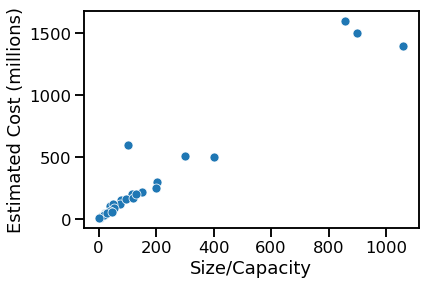

In [100]:
ax = sns.scatterplot(x="Size/Capacity", y="Estimated Cost (millions)", data=Power_Data)

In [103]:
scipy.stats.pearsonr(Power_Data['Size/Capacity'], Power_Data['Estimated Cost (millions)'])

(0.9676147594295178, 6.958427885850458e-19)

**Conclusion:** Since the p-value < 0.05, we reject  the Null hypothesis and conclude that there  exists a relationship between  Size Capacity and the Estimated Cost

### Second and Third Hypotesis

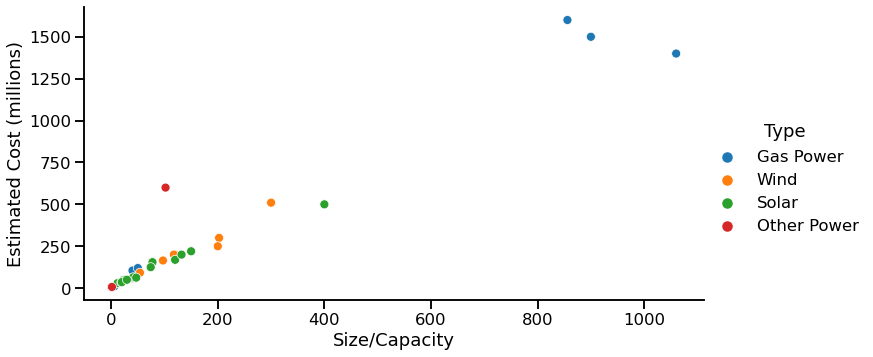

In [95]:
sns.relplot(x="Size/Capacity", y="Estimated Cost (millions)", hue="Type", data=Power_Data, height=5, aspect=2)